# CNN - AE model validation

In [1]:
import os
import csv
import random
import umap
import numpy as np
from os import path
from scipy import stats
from sklearn import preprocessing
from sklearn.manifold.t_sne import TSNE
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits import mplot3d
%matplotlib inline

### Load data

In [2]:
# data directories
homedir = os.path.expanduser('~')
prjdir = 'data1/stratification_ILRM'
datadir = 'data'
outdir = path.join(homedir, prjdir, datadir, 'neurodev-disorder')
expdir = path.join(homedir, prjdir, datadir, 'experiments/neurodev-disorder-2019-03-14-05-15-16-nobn-noact-norelu-10-l64')
# sub-sampling
n_samples = None

# get the list of diagnosed diseases associated with mrns
with open(path.join(outdir, 'cohort-mrn_diseases.csv')) as f:
    rd = csv.reader(f)
    mrn_disease = {r[0]: r[1::] for r in rd}

# evaluate potential disease classes

# read encoded vectors file and ordered medical record numbers
with open(path.join(expdir, 'NDDmrns.csv')) as f:
    rd = csv.reader(f)
    mrns = [r[0] for r in rd]
    
# (1) first diagnosis
gt_disease = {}
for m in mrn_disease:
    if mrn_disease[m][0]!='pervasive developmental disorder' and mrn_disease[m][0]!='OTH' and m in mrns:
        gt_disease[m] = mrn_disease[m][0]
    else:
        pass

with open(path.join(expdir, 'NDDencoded_vect.csv')) as f:
    rd = csv.reader(f)
    encoded = [list(map(float, r)) for r in rd]

tmp_mrns = []
tmp_encoded = []
for idx, m in enumerate(mrns):
    if m in gt_disease.keys():
        tmp_mrns.append(m)
        tmp_encoded.append(encoded[idx])
    else:
        pass
mrns = tmp_mrns
encoded = tmp_encoded

In [3]:
len(gt_disease)

8137

In [4]:
set_mrns = set(mrns)
    
# read the vocabulary
with open(path.join(outdir, 'cohort-eval_vocab.csv')) as f:    
    rd = csv.reader(f)
#     next(rd)
    vocab = {r[1]: r[0] for r in rd}
len_vocab = len(vocab)

# read raw data
with open(path.join(outdir, 'cohort-eval_ehr.csv')) as f:
    rd = csv.reader(f)
    raw_ehr = {}
    for r in rd:
        if r[0] in gt_disease.keys():
            raw_ehr.setdefault(r[0], list()).extend(list(map(int, r[1::])))

In [5]:
len(raw_ehr)

8137

In [6]:
disease_count = {}
for d in gt_disease.values():
    if d not in disease_count:
        disease_count[d] = 1
    else:
        disease_count[d] += 1
print(len(gt_disease))

8137


In [7]:
disease_count

{'attention deficit': 5924, 'autism': 814, 'mental retardation': 1399}

>`svd_tfidf():` returns the SVD matrix of the TFIDF matrix of the raw ehr data;

>`silhouette_analysis():` hierarchical clustering on input data maximizing the Silhouette Index

>`single_plot():` one plot of all the clusters

>`nonoveralp_plot():` N different plots, one per cluster, with N = no. of clusters

> `outer_clustering_analysis():` external validation of clustering (entropy and Purity scores)

In [34]:
# Hierarchical clustering parameters
# Frequency count analysis parameters
ehr_strat_model = True

if ehr_strat_model == False:
    HCpar = {'linkage_clu':'complete',
             'affinity_clu':'cosine',
             'min_cl':3,
             'max_cl':11}
else:
    HCpar = {'linkage_clu':'ward',
             'affinity_clu':'euclidean',
             'min_cl':3,
             'max_cl':11}
FRpar = {'n_terms':10,
        'ty_terms':['icd9']}

In [35]:
# analyze clustering using silhouette scores
def silhouette_analysis(data,
                        min_clu=HCpar['min_cl'],
                        max_clu=HCpar['max_cl'],
                       preproc=False):
    if preproc:
        data = preprocessing.scale(data)
    # bound analysis range
    if min_clu < 2:
        min_clu = 2

    # run analysis for every clustering size
    best_silh = 0
    silh_scores = []
    for n in range(min_clu, max_clu, 1):
        hclu = AgglomerativeClustering(n_clusters=n,
                                       linkage=HCpar['linkage_clu'],
                                       affinity=HCpar['affinity_clu'])
        lbl = hclu.fit_predict(data).tolist()
        silh = silhouette_score(data, lbl, metric=HCpar['affinity_clu'])
        if silh < 0:
            break
        print(' -- {0}: {1:.3f}'.format(n, silh))
        silh_scores.append(silh)
        if silh > best_silh:
            best_silh = silh
            n_clu = n
            label = lbl
    try:
        print('No. of clusters: {0} -- Silhouette Score: {1:.3f}\n'.format(
            n_clu, best_silh))

    except UnboundLocalError:
        hclu = AgglomerativeClustering(n_clusters=min_clu,
                                       linkage=HCpar['linkage_clu'],
                                       affinity=HCpar['affinity_clu'])
        n_clu = min_clu
        label = hclu.fit_predict(data).tolist()
        print('No. of Clusters: {0} -- Silhouette Score: {1:.3f}\n'.format(
            n_clu, best_silh))

    plt.plot(range(min_clu, max_clu, 1), silh_scores)
    return (n_clu, label, silh_scores)


# SVD matrix of the TFIDF matrix of the raw ehr data
def svd_tfidf(data, len_vocab, n_dimensions=200, tfidf=False):
    if tfidf:
    # apply tf-idf
        tfidf = TfidfTransformer()
        mtx = tfidf.fit_transform(data)
    else:
        scaler = MinMaxScaler()
        mtx = scaler.fit_transform(data)
    # reduce size of the matrix
    svd = TruncatedSVD(n_components=n_dimensions)
    svd_mtx = svd.fit_transform(mtx)

    return svd_mtx


# one plot with all the clusters
def single_plot(data, mrn_disease, colors, leg_labels=None):
    plt.figure(figsize=(20,10))
    for cl in set(mrn_disease):
        x = [d[0] for j, d in enumerate(data) if mrn_disease[j] == cl]
        y = [d[1] for j, d in enumerate(data) if mrn_disease[j] == cl]
        cols = [c for j, c in enumerate(colors) if mrn_disease[j] == cl]
        plt.xticks([])
        plt.yticks([])
        plt.scatter(x,y,c=cols, label=cl)
    if leg_labels is not None:
        plt.legend(labels=leg_labels, loc=2, fontsize=10, markerscale=2)
    else:
        plt.legend(loc=2, fontsize=10, markerscale=2)
#     plt.savefig(path.join(homedir, prjdir, datadir, 'neurodev-disorder/neurodev-data.png'))
 
    
# non-overlapping plots, one per cluster
def nonoverlap_plot(data, mrn_disease, colors):
    fig, ax = plt.subplots(len(set(mrn_disease)), 1, figsize=(20, 10*len(set(mrn_disease))))
    for idx, cl in enumerate(set(mrn_disease)):
        x = [d[0] for j, d in enumerate(data) if mrn_disease[j] == cl]
        y = [d[1] for j, d in enumerate(data) if mrn_disease[j] == cl]
        cols = [c for j, c in enumerate(colors) if mrn_disease[j] == cl]
        ax[idx].set_xticks([])
        ax[idx].set_yticks([])
        ax[idx].scatter(x, y, c=cols, label=cl)
        ax[idx].legend()

        
# external clustering analysis
def outer_clustering_analysis(data, gt_clu, preproc=False):
    
    if preproc:
        data = preprocessing.scale(data)
        
    label_clu = sorted(set(gt_clu))

    # format clustering ground truth
    didx = {d: i for i, d in enumerate(label_clu)}
    idxd = {i:d for d, i in didx.items()}
    gt = [didx[d] for d in gt_clu]

    # validate cluster number
    if len(label_clu) == 1:
        n_clu = 3
    else:
        n_clu = len(label_clu)

    # run clustering
    hclust = AgglomerativeClustering(n_clusters=n_clu,
                                     linkage=HCpar['linkage_clu'],
                                     affinity=HCpar['affinity_clu'])
    clusters = hclust.fit_predict(data).tolist()

    # count cluster occurrences
    cnt_clu = [0] * n_clu
    for c in clusters:
        cnt_clu[c] += 1
    class_clu = [[0] * n_clu for _ in range(len(label_clu))]
    for i, gi in enumerate(gt):
        class_clu[gi][clusters[i]] += 1

    # compute entropy and purity
    entropy = 0
    purity = 0
    pur_vec = []
    for j in range(0, max(clusters) + 1):
        en = 0
        pu = []
        for i in range(0, max(gt) + 1):
            pij = class_clu[i][j] / cnt_clu[j]
            pu.append(pij)
            if pij != 0:
                en += -(pij * np.log2(pij))
        max_pu = max(pu)
        print(
            'Cluster: {0} -- '
            'Entropy: {1:.3f}, '
            'Purity: {2:.3f}'.format(j, en, max_pu))
        for idx, p in enumerate(pu):
            print("P={0:.2f} in cluster disease {1}".format(p, idxd[idx]))
        cweight = cnt_clu[j] / len(gt)
        entropy += cweight * en
        purity += cweight * max_pu
        pur_vec.append(pu)
    print('Average Entropy: {0:.2f}'.format(entropy))
    print('Average Purity: {0:.2f}'.format(purity))
    
    return clusters, pur_vec, idxd

#Input: ehr lists corresponding to a cluster 
#Output: dictionary of term counts
def FreqDict(tokens):
    freq_dict = {}
    tok = []
    for seq in tokens:
        tok.extend(seq)
    
    tok = set(tok)
    for t in tok:
        for seq in tokens:
            if t in seq:
                if t not in freq_dict:
                    freq_dict[t] = 1
                else:
                    freq_dict[t] += 1
    return freq_dict
#Input: dictionary cluster:ehrs; list mrns
#Output:
def freq_term(data, pred_class):
    list_terms = []
    for subc in range(len(set(pred_class))):
        tmp_data = {}
        for j in range(len(pred_class)):
            if pred_class[j] == subc:
                tmp_data.setdefault(subc, list()).append([rd for rd in data[j] 
                                                           if rd!=0 and 
                                                           (str.split(vocab[str(rd)], "::")[0] 
                                                           in FRpar['ty_terms'])])
        print("Cluster {0} numerosity: {1}".format(subc, len(tmp_data[subc])))
        term_count = FreqDict(tmp_data[subc])
        clust_mostfreq = []
        for l in range(FRpar['n_terms']):
            try:
                MFMT = max(term_count, key=(lambda key: term_count[key]))
                num_MFMT = 0
                subc_termc = 0
                for ehr in tmp_data[subc]:
                    for e in ehr:
                        if e == MFMT:
                            subc_termc += 1
                for seq in raw_ehr.values():
                    for t in seq:
                        if t == MFMT:
                            num_MFMT += 1
                print("% most frequent term:{0} "
                       "= {1:.2f} ({2} out of {3} terms in the whole dataset"
                       "-- N patients in cluster {4})".format(vocab[str(MFMT)], 
                                                              subc_termc/num_MFMT, 
                                                              subc_termc,
                                                              num_MFMT,
                                                              term_count[MFMT]))
                term_count.pop(MFMT)
                clust_mostfreq.append(MFMT)
            except ValueError:
                pass
        print("\n")
        list_terms.append(clust_mostfreq)
    return list_terms

##Hierarchical clustering function. Max silhouette.
def hclust_ehr(data):
    best_silh = -1
    list_silh = []
    for nc in range(HCpar['min_cl'],HCpar['max_cl'],1):
        hclust = AgglomerativeClustering(n_clusters=nc, 
                                         linkage=HCpar['linkage_clu'], 
                                         affinity=HCpar['affinity_clu'])
        tmp_label = hclust.fit_predict(data).tolist()
        tmp_silh = silhouette_score(data, tmp_label, metric=HCpar['affinity_clu'])
        print(nc, tmp_silh)
        list_silh.append(float(tmp_silh))
        if tmp_silh > best_silh:
            best_silh = tmp_silh
            n_clust = nc
            label = tmp_label
    try:
        print("Number of clusters found:{0}, Silhouette score:{1:.3f}\n".format(n_clust, best_silh))
    except UnboundLocalError:
        hclust = AgglomerativeClustering(n_clusters=HCpar['min_cl'],
                                         linkage=HCpar['linkage_clu'],
                                         affinity=HCpar['affinity_clu'])
        n_clust = HCpar['min_cl']
        label = hclust.fit_predict(data).tolist()
        best_silh = silhouette_score(data, label)
        print("Number of clusters found:{0}, Silhouette score:{1:.3f}\n".format(n_clust, best_silh))
    return n_clust, label, list_silh

def chi_test(data, new_classes, term, mrns):
    count_mat = np.zeros((2, len(set(new_classes))), dtype=int)
    for c in set(new_classes):
        for idx, m in enumerate(mrns):
            if new_classes[idx] == c:
                if term in data[idx]:
                    count_mat[1][c] += 1
                else:
                    count_mat[0][c] += 1
    print("Count matrix:\n {0}".format(count_mat))
    chi2_stat, p_val, dof, ex = stats.chi2_contingency(count_mat)
    string = "Chi-squared test statistics: chi2_stat = {0} -- p_val = {1} -- dof = {2}".format(
                                                                  chi2_stat,
                                                                  p_val,
                                                                  dof)#row = classes, columns = vocab
    print(string)


##Internal clustering validation
def inner_clustering_analysis(disease_class, data, mrns, viz_data, preproc=False):
    if preproc:
        data = preprocessing.scale(data)
    dis_viz_data = []
    subclass_dis = []
    for dis in sorted(set(disease_class)):
        tmp_data = []
        tmp_mrn = []
        tmp_raw_ehr = []
        for idx, d in enumerate(disease_class):
            if d == dis:
                dis_viz_data.append(viz_data[idx])
                tmp_data.append(data[idx])
                tmp_mrn.append(mrns[idx])
                tmp_raw_ehr.append(raw_ehr[mrns[idx]])
        print("Inspecting disease: {0}\n".format(dis))
        n_clust, label, _ = hclust_ehr(tmp_data)
        subclass_dis.extend([dis + ': subclust ' + str(l) for l in label])
        list_terms = freq_term(tmp_raw_ehr, label)
        for l in range(len(set(label))):
            for lt in range(len(list_terms[l])):
                print("Odds ratio chi2 test for cluster {0}"
                      "term: {1}".format(l, vocab[str(list_terms[l][lt])]))
                try:
                    chi_test(tmp_raw_ehr, label, list_terms[l][lt], tmp_mrn)
                except ValueError:
                    print("empty class(es)")
                    pass
            print("\n\n")
    return(dis_viz_data, subclass_dis)

## Run t-SNE for data visualization

In [11]:
# initialize T-SNE
# reducer = umap.UMAP(n_neighbors=200, min_dist=0.5, metric = HCpar['affinity_clu'], n_components=2)
tsne = TSNE(n_components=2, n_iter=5000, perplexity=40, random_state=42)

In [12]:
# plot colors
col_dict = matplotlib.colors.CSS4_COLORS
c_out = ['mintcream', 'cornsilk', 'lavenderblush', 'aliceblue', 'antiquewhite', 'aqua', 'aquamarine', 'azure', 'beige', 'powderblue', 'floralwhite', 'ghostwhite',
 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightgreen', 'lightgrey', 'lightpink', 'lightsalmon', 'lightseagreen', 'lightskyblue',
 'lightslategray', 'lightslategrey', 'lightsteelblue', 'lightyellow', 'linen', 'palegoldenrod', 'palegreen', 'paleturquoise', 'palevioletred', 'papayawhip',
 'peachpuff', 'mistyrose', 'lemonchiffon', 'lightblue', 'seashell', 'white', 'blanchedalmond', 'oldlace', 'moccasin', 'snow', 'darkgray',
 'ivory', 'whitesmoke']
colormap = [c for c in col_dict if c not in c_out]

In [13]:
# t-SNE on the CNN encoded vectors
# encoded = preprocessing.scale(encoded)
# encoded_umap = reducer.fit_transform(encoded).tolist()
encoded_tsne = tsne.fit_transform(encoded).tolist()

print('Computed: CNN - AE encoded vectors umap')

Computed: CNN - AE encoded vectors umap


### t-SNE visualization and external clustering validation

In [14]:
# choose the disease classes: first_disease, oth_disease
disease_class_first = [gt_disease[m] for m in mrns]
# raw_disease_class_first = [gt_disease[m] for m in mrn_list]
# lstm_disease_class_first = [gt_disease[m] for m in lstm_mrns]
disease_dict = {d: i for i, d in enumerate(set(disease_class_first))}

### CNN - AE encodings

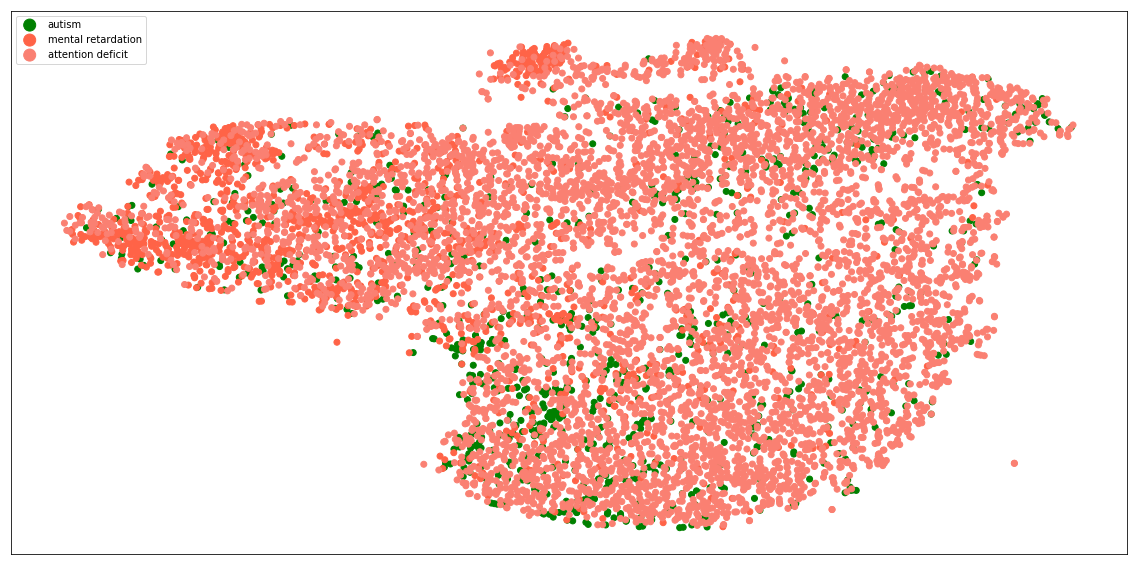

In [15]:
# plot data
colors_en1 = [colormap[disease_dict[v]] for v in disease_class_first]
single_plot(encoded_tsne, disease_class_first, colors_en1)

In [63]:
# nonoverlap_plot(encoded_umap, disease_class_first, colors_en1)

In [36]:
# plot cluster results
clusters, pur_vec, idxd = outer_clustering_analysis(encoded, disease_class_first, preproc=True)

Cluster: 0 -- Entropy: 1.340, Purity: 0.555
P=0.56 in cluster disease attention deficit
P=0.10 in cluster disease autism
P=0.34 in cluster disease mental retardation
Cluster: 1 -- Entropy: 0.761, Purity: 0.850
P=0.85 in cluster disease attention deficit
P=0.08 in cluster disease autism
P=0.07 in cluster disease mental retardation
Cluster: 2 -- Entropy: 0.824, Purity: 0.823
P=0.82 in cluster disease attention deficit
P=0.13 in cluster disease autism
P=0.05 in cluster disease mental retardation
Average Entropy: 1.00
Average Purity: 0.73


Cluster numerosity:3181
Cluster numerosity:2977
Cluster numerosity:1979


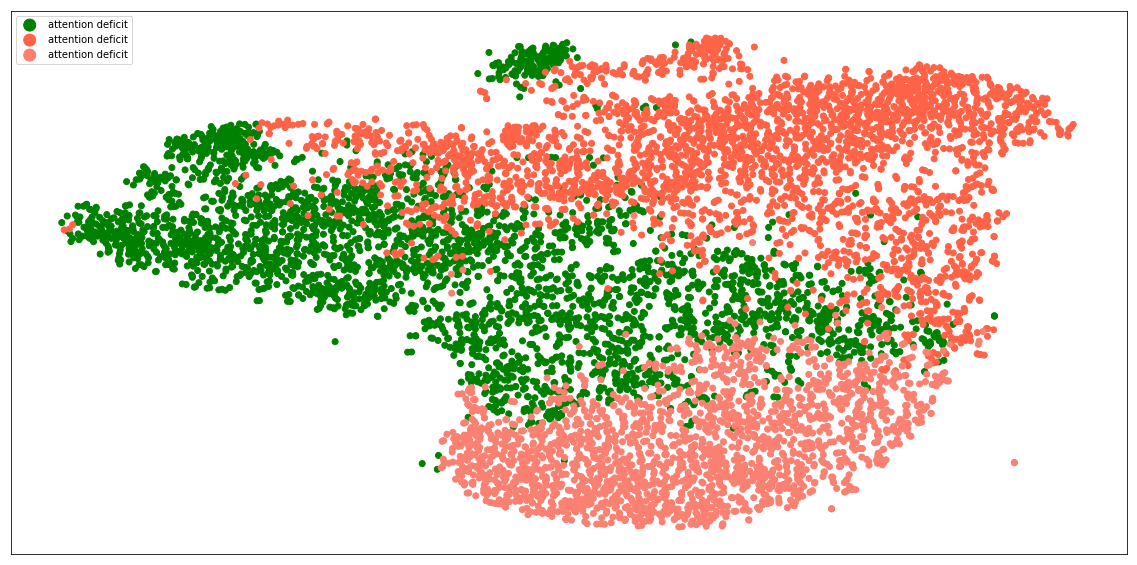

In [37]:
labels = []
for p in pur_vec:
    idx = p.index(max(p))
    labels.append(idxd[idx])
colors_en2 = [colormap[v] for v in clusters]
single_plot(encoded_tsne, clusters, colors_en2, labels)
for i in range(len(set(clusters))):
    print("Cluster numerosity:{0}".format(clusters.count(i)))

[0.15 1.15 2.15]
[0.3 1.3 2.3]
[0.45 1.45 2.45]


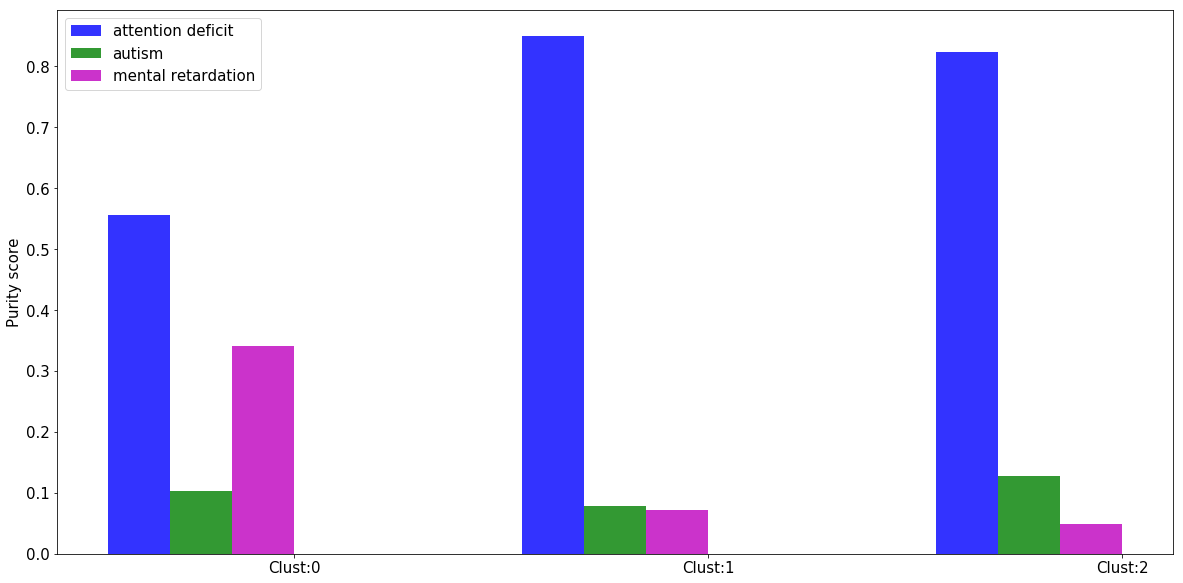

In [38]:
# data to plot
n_groups = 3
colors_en2 = ['b', 'g', 'm']
# create plot
fig, ax = plt.subplots(figsize=(20,10))
index = np.arange(n_groups)
bar_width = 0.15
opacity = 0.8

for idx in range(n_groups):
    rects = plt.bar(index, [p[idx] for p in pur_vec], bar_width,
    alpha=opacity,
    color=colors_en2[idx],
    label=idxd[idx])
    index = index + bar_width
    print(index)
plt.xlabel('')
plt.ylabel('Purity score', size=15)
plt.title('')
plt.xticks(np.arange(n_groups) + 0.375, 
           ('Clust:0', 'Clust:1', 'Clust:2'), size=15)
plt.yticks(size=15)
plt.legend(markerscale=5, fontsize=15)
 
# plt.tight_layout()
plt.show()


 -- 2: 0.202
 -- 3: 0.187
 -- 4: 0.192
 -- 5: 0.199
 -- 6: 0.189
 -- 7: 0.186
 -- 8: 0.143
 -- 9: 0.106
 -- 10: 0.098
No. of clusters: 2 -- Silhouette Score: 0.202



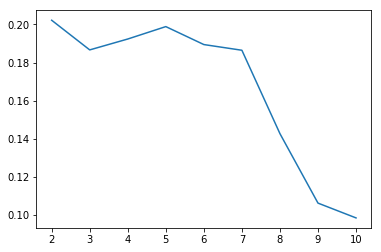

In [73]:
 _, _, _ = silhouette_analysis(encoded, preproc=False)

In [39]:
# inner clustering analysis
encoded_subplots, en_sub_clust = inner_clustering_analysis(disease_class_first, encoded, mrns, 
                                                           encoded_tsne, preproc=True)

Inspecting disease: attention deficit

3 0.1328594167854572
4 0.13504455487180567
5 0.08321791635800177
6 0.0805761415566909
7 0.07181162843485969
8 0.06926809307362114
9 0.06759244804094718
10 0.0644176783102479
Number of clusters found:4, Silhouette score:0.135

Cluster 0 numerosity: 2112
% most frequent term:icd9::Attention deficit disorder with hyperactivity::314.01::C1263846 = 0.13 (6249 out of 46765 terms in the whole dataset-- N patients in cluster 1667)
% most frequent term:icd9::Attention deficit disorder without mention of hyperactivity::314.00::C0339002 = 0.31 (2918 out of 9379 terms in the whole dataset-- N patients in cluster 895)
% most frequent term:icd9::Oppositional defiant disorder::313.81::C0029121 = 0.08 (522 out of 6728 terms in the whole dataset-- N patients in cluster 246)
% most frequent term:icd9::Personal history of allergy to medicinal agents::V14::C0260483 = 0.03 (271 out of 8097 terms in the whole dataset-- N patients in cluster 221)
% most frequent term:ic

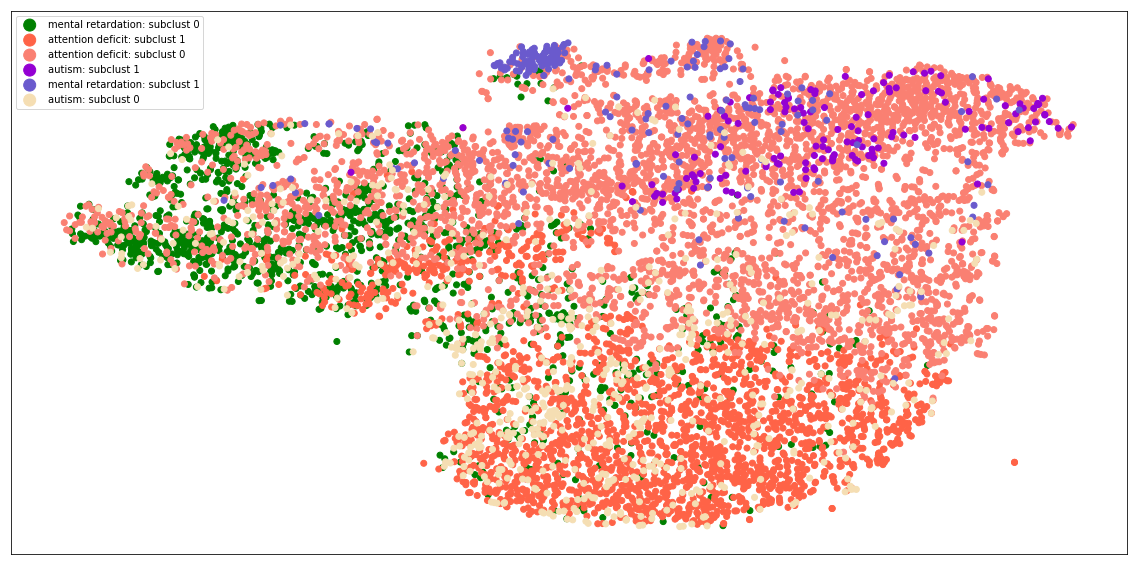

In [24]:
encoded_new_disease_dict = {}
for idx, nd in enumerate(set(en_sub_clust)):
    encoded_new_disease_dict[nd] = idx
colors_en3 = [colormap[encoded_new_disease_dict[v]] for v in en_sub_clust]
single_plot(encoded_subplots, en_sub_clust, colors_en3)